# Extraction, Transformation, Load, Analysis and Visualization of Song Data from Taylor Swift's Complete Collection Playlist using Spotify API

## 0. Set Up Environment

### 0.1 Install Spotipy
Installed Spotipy into conda for access in Jupyter notebook. 
Spotipy is a Python library used to access the Spotify Web API and gather data.
Spotipy was accessed [here](https://anaconda.org/conda-forge/spotipy).
Spotipy documentation can be found [here](https://spotipy.readthedocs.io/en/latest/). 
Once Spotipy has been installed, this step should not need to be repeated.

In [2]:
conda install -c conda-forge spotipy

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


### 0.2 Import relevant data science libraries

Import the following libraries to help perform data transformation and visualization.
- **Pandas** will be used to work with our data in a dataframe. Pandas documentation can be found [here](https://pandas.pydata.org/docs/). 
- **NumPy** will be used to perform computations on our data. NumPy documentation can be found [here](https://numpy.org/doc/stable/)
- **SciPy** will be used to perform more computations on our data. Specifically, we import *pearsonr* to find the correlation coefficient of our data. SciPy documentation can be found [here](https://docs.scipy.org/doc/scipy/).
- *Pyplot* from **Matplotlib** will be used to help visualize our data by plotting it. Matplotlib documentation can be found [here](https://matplotlib.org/stable/#matplotlib-release-documentation).

In [67]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

### 0.3 Set up access to Spotify API 

Import Spotipy, which should be installed. Authorize access to Spotify by using the Client credentials OAuth flow since we will not be accessing any user profile data. More information on this can be found [here](https://developer.spotify.com/documentation/general/guides/authorization/). 

Set up access to Spotify Web API (documentation can be found [here](https://developer.spotify.com/documentation/web-api/)). This required creating a new project. From this project, retrieve the client id and client secret key.

Set client_credentials_manager with the values of client_id and client_secret from project. Create Spotipy object sp to access Spotify Web API using client credentials.

In [37]:
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials

#client_id=2505cc7cfe89480fa2e2b43834ee462b
#client_secret=30d0beaa38d54f29a781e4b389ece620

client_credentials_manager = SpotifyClientCredentials(client_id='2505cc7cfe89480fa2e2b43834ee462b', client_secret='30d0beaa38d54f29a781e4b389ece620')
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## 1. Extraction

### 1.1 Define a function to get all tracks from a given playlist

Define a function that uses the API call user_playlist_tracks() - more information on this API call can be found [here](https://spotipy.readthedocs.io/en/latest/#spotipy.client.Spotify.user_playlist_tracks). The while loop is utilized to extend the results past the default limit of 100 track per call.  

In [4]:
def get_playlist_tracks(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return playlist_tracks

### 1.2 Extract raw data

For our dataset, we will be extracting data from "Taylor Swift Complete Collection" playlist by Taylor Swift on spotify. This playlist can be found [here](https://open.spotify.com/playlist/4GtQVhGjAwcHFz82UKy3Ca?si=d86ebcde55e7426a). 
- Use the split function for a string to reduce this link into the playlist URI. 

In [5]:
playlist_link = "https://open.spotify.com/playlist/4GtQVhGjAwcHFz82UKy3Ca?si=1a1f5e2156b24276"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]

- Create a list of playlist features, as listed in Spotipy documentation
- Create a data frame for the playlist data with columns set to the strings in playlist_features_list

In [ ]:
playlist_features_list = ["artist","album","track_name","track_id","danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]    
playlist_df = pd.DataFrame(columns = playlist_features_list)

- Call get_playlist_tracks function on our playlist using the playlist URI and call this result tracks
- Create a data frame from the raw data using pandas.DataFrame() on tracks
- Convert raw data to csv and save locally

In [7]:
tracks = get_playlist_tracks("spotify",playlist_URI)
raw_data_df = pd.DataFrame(tracks)
raw_data_df.to_csv("TaylorSwift_CompleteCollection_RawTrackData.csv")

## 2. Transformation

### 2.1 Initial concatenation into dataframe 

For each track in the playlist:
- Create an empty dictionary to store track data in key-value pairs with playlist feature as key and given attribute for track as value 
- Store values for track artist, album, name, and id
- Get audio features of track using audio_features call - documentation on this call found [here](https://spotipy.readthedocs.io/en/latest/#spotipy.client.Spotify.audio_features)
- For each playlist feature, save value of track for that feature in playlist features dictionary
- Create a dataframe for the track data, then concatenate with pd.concat() function -- more info can be found [here](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)
    

In [ ]:
for track in tracks:
    
    playlist_features = {}
        
    playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
    playlist_features["album"] = track["track"]["album"]["name"]
    playlist_features["track_name"] = track["track"]["name"]
    playlist_features["track_id"] = track["track"]["id"]
        
    audio_features = sp.audio_features(playlist_features["track_id"])[0]
    for feature in playlist_features_list[4:]:
        playlist_features[feature] = audio_features[feature]
            
    track_df = pd.DataFrame(playlist_features, index = [0])
    playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)

### 2.2 Additional cleaning

Drop unnecessary columns using pandas.DataFrame.drop function -- more information on this function can be found [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html#pandas-dataframe-drop)

In [ ]:
columns_to_drop = ["key","loudness","mode","speechiness","instrumentalness","liveness","time_signature"]
playlist_df.drop(columns_to_drop, axis=1,inplace=True)

## 3. Load

### 3.1 Save final data

Save cleaned playlist data frame as final_data for east and clear future reference. 

In [69]:
final_data = playlist_df

### 3.2 Save final data as a CSV file

Use pandas.DataFrame.to_csv function to save a copy of final data set as csv -- more information on this function can be found [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html?highlight=csv#pandas-dataframe-to-csv)

In [68]:
final_data.to_csv("TaylorSwift_CompleteData.csv")

## 4. Analysis and Visualization

### 4.1 Save some columns from final_data for easy acces

In [15]:
danceability_col = final_data["danceability"]
energy_col = final_data["energy"]
valence_col = final_data["valence"]
tempo_col = final_data["tempo"]

### 4.2 Analyze

Describe some of the columns using the pandas.DataFrame.describe() function - more information on this function can be found [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html#pandas-dataframe-describe)

In [71]:
danceability_col.describe()

count    311.000000
mean       0.571026
std        0.118374
min        0.197000
25%        0.489500
50%        0.584000
75%        0.647000
max        0.897000
Name: danceability, dtype: float64

In [72]:
energy_col.describe()

count    311.000000
mean       0.567492
std        0.201135
min        0.131000
25%        0.415000
50%        0.578000
75%        0.726500
max        0.984000
Name: energy, dtype: float64

In [73]:
valence_col.describe()

count    311.000000
mean       0.394956
std        0.190725
min        0.037400
25%        0.240000
50%        0.380000
75%        0.522000
max        0.942000
Name: valence, dtype: float64

In [74]:
tempo_col.describe()

count    311.000000
mean     122.783492
std       31.170063
min       57.964000
25%       96.483500
50%      119.386000
75%      145.055500
max      208.918000
Name: tempo, dtype: float64

Compute the correlation coefficient between two columns, which we will visualize in 4.3. Use the pearsonr function from SciPy. 

In [38]:
p_EV = pearsonr(energy_col,valence_col)
print(f"The coefficient of energy and valence is {p_EV[0]}")

The coefficient of energy, valence is 0.4877350845329559


### 4.3 Visualization

- Use pyplot to create a scatterplot comparing the energy and valence of each song. 
- Add axes labels and a title. 
    - matplotlib.pyplot.xlabel documentation [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlabel.html)
    - matplotlib.pyplot.ylabel documentation [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylabel.html)
    - matplotlib.pyplot.title documentation [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.title.html#matplotlib-pyplot-title)
- Add a box of text to the figure to define energy and valence
    - matplotlib.pyplot.figtext documentation [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figtext.html)

Text(0.97, 0.3, 'Energy describes the perceived measure of intensity and activity\nin a song. Features contributing to the energy\nof a song include dynamic range, perceived loudness, timbre,\nonset rate, and general entropy. Valence describes musical positiveness,\nsuch that songs with higher valence values sound more\npositive (eg, happier, more cheerful) while lower valence\nvalues signify more negative sounding songs (eg. sad, angry).')

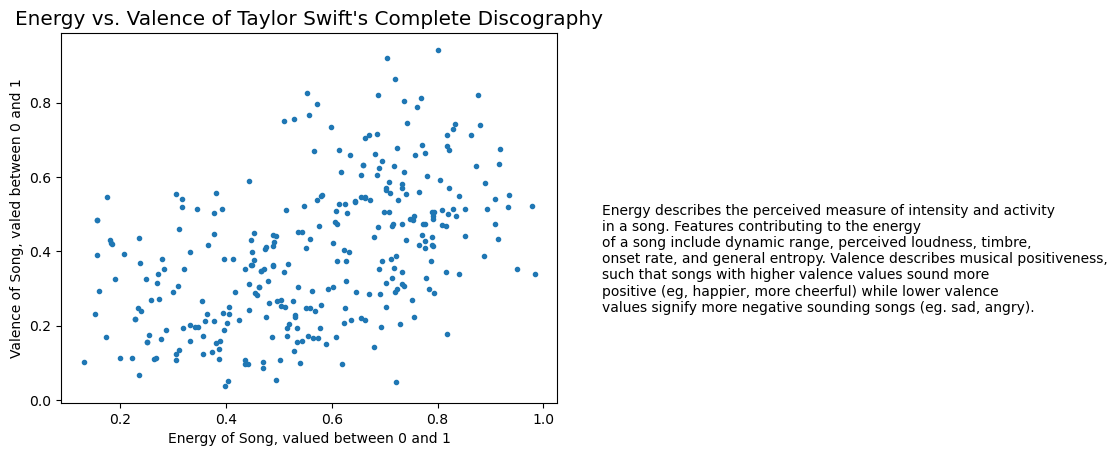

In [76]:
plt.scatter(energy_col,valence_col,marker=".")

plt.xlabel("Energy of Song, valued between 0 and 1")
plt.ylabel("Valence of Song, valed between 0 and 1")

plt.title("Energy vs. Valence of Taylor Swift's Complete Discography",size='x-large')
plt.figtext(x=0.97,y=0.3,s="Energy describes the perceived measure of intensity and activity\nin a song. Features contributing to the energy\nof a song include dynamic range, perceived loudness, timbre,\nonset rate, and general entropy. Valence describes musical positiveness,\nsuch that songs with higher valence values sound more\npositive (eg, happier, more cheerful) while lower valence\nvalues signify more negative sounding songs (eg. sad, angry).")

### 4.4 Insights

Based on the computations in 4.2 and the visualization in 4.3, we can draw a few insights from this data. 

Firstly, based on the descriptive statistics for danceability, we can see that most of Taylor Swift's songs sit above the midpoint of the range for danceability. This suggests most of her discography can be considered relatively danceable. 

Second, based on the descriptive statistics for valence, we can see that the 75th percentile of songs is 0.522, so a majority of the songs are not considered quite positive. This could further extrapolate to a conjecture regarding the subject matter of the songs. 

Third, the correlation coefficient between energy and valence is ~0.488. This suggests there is a moderate positive correlation between energy and valence of a song. Combining this number with our visualization of these two columns in a scatter plot, we observe a that as energy of a song increases, the valence of the song also tends to increase. We can conclude that a more energetic song will tend to be happier based on these statistics. 